# load data

In [4]:
%run ./function.ipynb

In [5]:
PATH = 'C:/Users/FinLab615_83/Desktop/MetaEdge/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [6]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [7]:
df['TO_SAR'].value_counts()

0    86324
1      446
Name: TO_SAR, dtype: int64

In [8]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [9]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
print(f'train_set:{train_set.shape}\n' + f'test_set:{test_set.shape}')

train_set:(52060, 38)
test_set:(34709, 38)


In [10]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

# Function

In [10]:
def intialPoint(feature, data):
    return data[feature][np.random.randint(0, len(data))]

In [11]:
def conditionalEntropy(new_sam_0, new_sam_1):
    total = len(new_sam_1) + len(new_sam_0)
    return Entropy(new_sam_0, SAR_type) * (len(new_sam_0) / total) \
            + Entropy(new_sam_1, SAR_type) * (len(new_sam_1) / total)

In [12]:
def recallFilterRate(x_thre, y_thre, x_name, y_name, data):
    idx1 = set(data[data[x_name] > x_thre].index)
    idx2 = set(data[data[y_name] > y_thre].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

In [13]:
def plot_results(results):
    x = list(results.loc[results['iteration number'] % 50 == 0].index)
    x.append(len(results) - 1)

    plt.figure()
    plt.plot(x, results.loc[x, 'information gain'], 'o--')
    plt.plot(x, results.loc[x, 'recall'], 'o--')
    plt.plot(x, results.loc[x, 'filter rate'], 'o--')
    plt.xlabel('iteration number')

    plt.legend(['information gain', 'recall', 'filter rate'])
    plt.show()

In [14]:
def plot_seperator(results):
    x = list(results.loc[results['iteration number'] % 50 == 0].index)
    x.append(len(results) - 1)

    plot_name = ['information gain', 'recall', 'filter rate']
    color = ['r', 'b', 'g']
    plt.figure()
    for i, name in enumerate(plot_name):
        plt.subplot(2,2,i+1)
        plt.plot(x, results.loc[x, name], 'o--', color= color[i])
        plt.title(name)
    plt.tight_layout()
    plt.show()

In [15]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    #print(len(new_sam_1), len(new_sam_0))
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [16]:
def gradientIG(point, x_name, y_name, data):
    x1 = float(point[0])
    y1 = float(point[1])

    if len(np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')[auxiliary_point_select_behind_x]
    elif len(np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')[-auxiliary_point_select_behind_x]
    else:
        raise ValueError(f'error when x1: {x1}, y1: {y1}')

    if len(np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')[auxiliary_point_select_behind_y]
    elif len(np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')[-auxiliary_point_select_behind_y]
    else:
        raise ValueError(f'error when x1: {x1}, y1: {y1}')

    delta_x = x2 - x1
    delta_y = y2 - y1
    
    z = informationGain(point, x_name, y_name, data)
    z_delta_x = informationGain(np.array([[x2], [y1]]), x_name, y_name, data)
    z_delta_y = informationGain(np.array([[x1], [y2]]), x_name, y_name, data)
    
    grad = np.array([[(z_delta_x - z) / delta_x], [(z_delta_y - z) / delta_y]])
    return grad

In [17]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [18]:
def auxiliaryPoint(point, feature, number, data):
    delta = (data[feature].max() - data[feature].min()) / number
    
    return point + delta

In [19]:
def lineSearch(point, update_direction, grads, data):
    a = 1
    c1 = 1e-4
    c2 = 0.9
    z = informationGain(point, x_name, y_name, data)
    new_point = point + a * update_direction
    new_grads = gradientIG(point, x_name, y_name, data)
    new_z = informationGain(new_point, x_name, y_name, data)
    print(f'before loop')
    while (new_z >= z + (c1 * a * grads.T @ update_direction)) or (new_grads.T @ update_direction <= c2 * (grads.T @ update_direction)):
        a *= 0.5
        new_point = point + a * update_direction
        new_grads = gradientIG(new_point, x_name, y_name, data)
        
    return a

In [20]:
def Recall(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    idx = list(idx1 & idx2)
    #print(f'idx:{len(idx)}')
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 1 and new sam 0 are overlapped')
    
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    return -(TP / (TP + FN))

In [21]:
def RecallFilterRate(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

In [22]:
def gradientPenalty(point, upperbound=np.zeros((2,1))):
    if np.any(point < 0): # any 是只要有一個是 True 就 output True，但 all 是要全部都為 True 才 output True
        raise ValueError('point are negative!')

    if np.linalg.norm(upperbound) == 0:
        return 1 / point
    else:
        return 1 / (upperbound - point)

In [23]:
def gradientRecall(point, x_name, y_name, data):
    x1 = float(point[0])
    y1 = float(point[1])

    if len(np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')[auxiliary_point_select_behind_x]
    else:
        x2 = np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')[-auxiliary_point_select_behind_x]
    
    if len(np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')[auxiliary_point_select_behind_y]
    else:
        y2 = np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')[-auxiliary_point_select_behind_y]
    
    delta_x = x2 - x1
    delta_y = y2 - y1

    z = Recall(point, x_name, y_name, data)
    z_delta_x = Recall(np.array([[x2], [y1]]), x_name, y_name, data)
    z_delta_y = Recall(np.array([[x1], [y2]]), x_name, y_name, data)

    grad = np.array([[(z_delta_x - z) / delta_x], [(z_delta_y - z) / delta_y]])

    return grad

In [24]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-(sigmoid_b + sigmoid_w * x)))

In [25]:
def sigmoidDiff(x):
    tmp = sigmoid(x)
    return tmp * (1 - tmp)

# confined range newton 
we use old two dimensional serach two define the subset of data where the recall is higher than 0.8 <br>
老師的想法是用學姊的方法找到 Recall 大於 0.8 的點當成 newton method 的 initial point，但我的想法是用那個點去縮小可行解範圍，不過在後續計算 Recall 會變成用 confined train set 計算，但應該是用 original train set 才對

In [99]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []

FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
        
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 8442.999999999958, 668833.6, 1074600.0000000002, 1553043.6, 6840000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 9.800000000000011, 17.0, 98.0]

[0.0, 101719.60000000002, 945568.0, 1050000.0, 1150000.0, 1200048.0, 1392000.0, 1888417.6000000006, 2400000.0, 10600030.0]

[0.0, 3.200000000000003, 6.0, 10.0, 14.0, 17.0, 20.0, 24.0, 39.80000000000001, 149.0]



In [100]:
LOGIC = "OR"
default_number_of_credit  = 5
default_credit_amt = 985500
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, \
                           train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.23322307785412544 number of max val:  1
Rank: 10, countMax: 1, 100- countZero: 10
67th, recall: 0.20224719101123595, val1: 5.0, val2: 1074600.0000000002
77th, recall: 0.15355805243445692, val1: 9.800000000000011, val2: 1074600.0000000002
68th, recall: 0.10112359550561797, val1: 5.0, val2: 1553043.6
87th, recall: 0.0749063670411985, val1: 17.0, val2: 1074600.0000000002
78th, recall: 0.07116104868913857, val1: 9.800000000000011, val2: 1553043.6
88th, recall: 0.03745318352059925, val1: 17.0, val2: 1553043.6
79th, recall: 0.011235955056179775, val1: 9.800000000000011, val2: 6840000.0
69th, recall: 0.011235955056179775, val1: 5.0, val2: 6840000.0
98th, recall: 0.003745318352059925, val1: 98.0, val2: 1553043.6
97th, recall: 0.003745318352059925, val1: 98.0, val2: 1074600.0000000002
********************************


In [101]:
LOGIC = "OR"
default_debit_amt = 985500
default_number_of_debit  = 5

candidate_rule2 = Search2D(debit_amt_threshold, number_of_debit_threshold, 'Debit_Amt','number_of_Debit' , default_debit_amt,\
                           default_number_of_debit , train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.5699796274858672 number of max val:  1
Rank: 10, countMax: 1, 100- countZero: 49
32th, recall: 0.5543071161048689, val1: 1050000.0, val2: 6.0
33th, recall: 0.4606741573033708, val1: 1050000.0, val2: 10.0
42th, recall: 0.45692883895131087, val1: 1150000.0, val2: 6.0
34th, recall: 0.4044943820224719, val1: 1050000.0, val2: 14.0
43th, recall: 0.3707865168539326, val1: 1150000.0, val2: 10.0
52th, recall: 0.3595505617977528, val1: 1200048.0, val2: 6.0
35th, recall: 0.3333333333333333, val1: 1050000.0, val2: 17.0
44th, recall: 0.3258426966292135, val1: 1150000.0, val2: 14.0
45th, recall: 0.27715355805243447, val1: 1150000.0, val2: 17.0
53th, recall: 0.27340823970037453, val1: 1200048.0, val2: 10.0
********************************


In [102]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [105]:
# apply on testing set
split_results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'Debit_Amt','number_of_Debit','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
        idx = list(set(train_set[train_set['number_of_Credit']>=thre1].index) & set(train_set[train_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(train_set[train_set['Debit_Amt']>=thre3].index) & set(train_set[train_set['number_of_Debit']>=thre4].index))
        new_SAM_1_rule1 = train_set.iloc[idx]
        new_SAM_1_rule2 = train_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = train_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=train_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = train_set.shape[0]
        split_results = split_results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'Debit_Amt':thre3, 'number_of_Debit':thre4, 'SAR':train_set[train_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':train_set[train_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [160]:
split_point = split_results.sort_values(by= 'recall', ascending= False).iloc[0]
split_point

number_of_Credit            5
Credit_Amt            1074601
Debit_Amt             1050000
number_of_Debit             6
SAR                       267
Non SAR                 51793
newSAM=1_SAR=1(TP)        184
newSAM=1_SAR=0(FP)      35923
newSAM=0_SAR=1(FN)         83
newSAM=0_SAR=0(TN)      15870
recall                 0.6891
filter rate            0.3064
Name: 99, dtype: object

In [127]:
idx = list(set(train_set[train_set['number_of_Credit']>=split_point['number_of_Credit']].index) & set(train_set[train_set['Credit_Amt']>=split_point['Credit_Amt']].index))
idx1 = list(set(train_set[train_set['Debit_Amt']>=split_point['Debit_Amt']].index) & set(train_set[train_set['number_of_Debit']>=split_point['number_of_Debit']].index))
new_train_set = train_set.iloc[idx].reset_index(drop= True)
print(f"split threshold Credit_Amt: {split_point['Credit_Amt']}, number_of_Credit: {split_point['number_of_Credit']}, Debit_Amt: {split_point['Debit_Amt']}, number_of_Debit: {split_point['number_of_Debit']}")
print(f'original trian set: {len(train_set)}, new train_set: {len(new_train_set)}')

split threshold Credit_Amt: 1074601, number_of_Credit: 5, Debit_Amt: 1050000, number_of_Debit: 6
original trian set: 52060, new train_set: 20716


In [142]:
new_train_set['Credit_Amt'].value_counts().index

Float64Index([1200000.0, 1300000.0, 1100000.0, 1500000.0, 1600000.0, 1800000.0,
              2000000.0, 1700000.0, 1400000.0, 1900000.0,
              ...
              1336080.0, 1113506.0, 3613000.0, 5618000.0, 3866893.0, 1192815.0,
              8483000.0, 1950500.0, 3678935.0, 1865654.0],
             dtype='float64', length=12817)

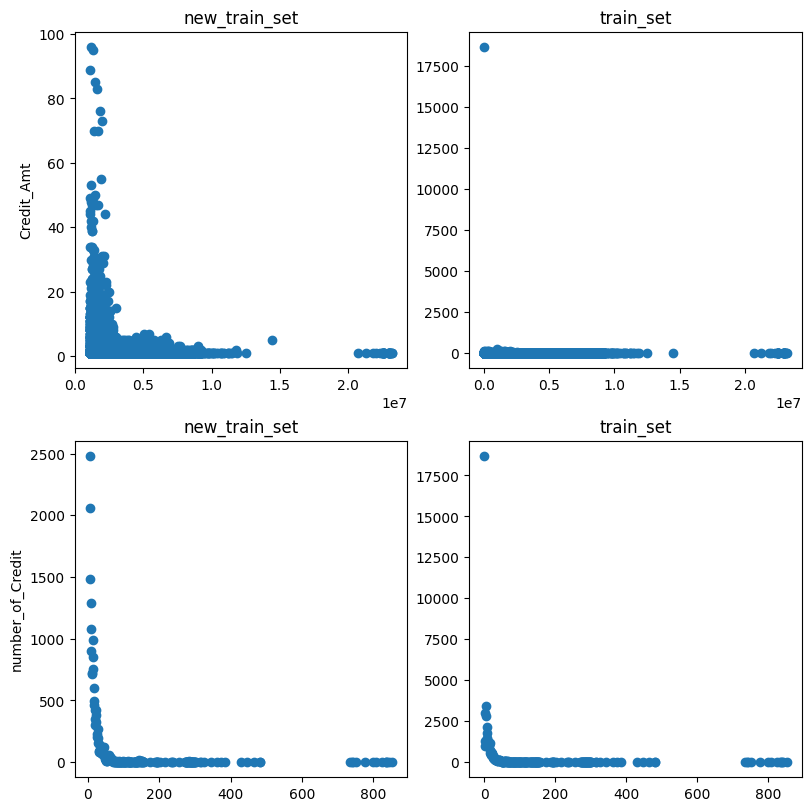

In [148]:
fig, axs = plt.subplots(2,2, figsize= (8, 8), constrained_layout=True)
col1 = ['Credit_Amt', 'number_of_Credit']
for i, feature in enumerate(col1):
    x, y = new_train_set[feature].value_counts().index, new_train_set[feature].value_counts().values
    axs[i][0].scatter(x= x, y= y)
    axs[i][0].set_title('new_train_set')
    axs[i][0].set_ylabel(feature)

for i, feature in enumerate(col1):
    x, y = train_set[feature].value_counts().index, train_set[feature].value_counts().values
    axs[i][1].scatter(x= x, y= y)
    axs[i][1].set_title('train_set')

plt.show()

In [149]:
def BFGSWithUpDownPenaltyRecall(point0, x_name, y_name, upperbound, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradRecall = gradientRecall(point0, x_name, y_name, data)
    gradientPenaltyDown = gradientPenalty(point0)
    gradientPenaltyUp = gradientPenalty(point0, upperbound)
    recall = Recall(point0, x_name, y_name, data)
    information_gain = informationGain(point0, x_name, y_name, data)
    grads = gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * gradRecall + gamma * (gradientPenaltyDown + gradientPenaltyUp)
    print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
    H = np.eye(d)
    point = point0
    n = 1

    print(f'gradIG:\n{gradIG}')
    print(f'gradRecall:\n{gradRecall}')
    print(f'gradPenaltyDown:\n{gradientPenaltyDown}')
    print(f'gradPenaltyUp:\n{gradientPenaltyUp}')
    print(f'Hessian matrix:\n{H}')


    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'maximum iteration reached!')
            break
        
        update_direction = -H @ grads
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)

        print(f'n={n}, new x1:{float(new_point[0])}, new y1: {float(new_point[1])},\ninformation gain: {information_gain}, recall:{recall}, filter rate:{filter_rate}')

        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)

        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gradRecall = gradientRecall(new_point, x_name, y_name, data)
        new_gradPenaltyDown = gradientPenalty(new_point)
        new_gradPenaltyUp = gradientPenalty(new_point, upperbound)
        new_grads = new_gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * new_gradRecall + gamma * (new_gradPenaltyDown + new_gradPenaltyUp)

        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))

        grads = new_grads
        point = new_point
        print('*'*32)
        print(f'new_gradIG:\n{new_gradIG}')
        print(f'new_gradRecall:\n{new_gradRecall}')
        print(f'new_gradPenaltyDown:\n{new_gradPenaltyDown}')
        print(f'new_gradPenaltyUp:\n{new_gradPenaltyUp}')
        print(f'new_Hessian matrix:\n{H}')
        print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
        
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping')
    
    return results

In [151]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
step_size = 0.001
gamma = 1e-5
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
upperbound = np.array([[train_set[x_name].max()], [train_set[y_name].max()]])
sigmoid_b = 0.8
sigmoid_w = 5
father_entropy = Entropy(train_set, SAR_type)

#### step_size= 0.001

In [152]:
if __name__ == '__main__':
    np.random.seed(1111)
    x1 = intialPoint('Credit_Amt', new_train_set)
    y1 = intialPoint('number_of_Credit', new_train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithUpDownPenaltyRecall(point, x_name, y_name, upperbound, new_train_set)

initial  point x1:1377799.0, y1:20.0
recall:-0.18518518518518517, sigmoid:0.4685600536992198
gradIG:
[[ 1.26090175e-12]
 [-8.00902673e-06]]
gradRecall:
[[0.        ]
 [0.00462963]]
gradPenaltyDown:
[[7.25795272e-07]
 [5.00000000e-02]]
gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-8.30670555e-12]
 [ 2.66025370e-05]]
n=1, new x1:1377799.0, new y1: 20.000000026602535,
information gain: -0.02026582950449117, recall:0.18518518518518517, filter rate:0.8240007723498745
********************************
new_gradIG:
[[-5.31300013e-11]
 [-7.74154878e-06]]
new_gradRecall:
[[0.        ]
 [0.00462963]]
new_gradPenaltyDown:
[[7.25795272e-07]
 [4.99999999e-02]]
new_gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
new_Hessian matrix:
[[1.00000000e+00 5.37076315e-06]
 [5.37076315e-06 3.12691012e-03]]
recall:0.18518518518518517, sigmoid:0.8488905593620004
update_direction:
[[1.34569220e-10]
 [5.65812068e-08]]
n=2, new x1:1377799.0, new y1: 

In [153]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,1377799.0,16.802688,1377799.0,16.799557,-0.020268,0.240741,0.775488
996,997.0,1377799.0,16.799557,1377799.0,16.796424,-0.020268,0.240741,0.775488
997,998.0,1377799.0,16.796424,1377799.0,16.793287,-0.020268,0.240741,0.775488
998,999.0,1377799.0,16.793287,1377799.0,16.790147,-0.020268,0.240741,0.775488
999,1000.0,1377799.0,16.790147,1377799.0,16.787005,-0.020268,0.240741,0.775488


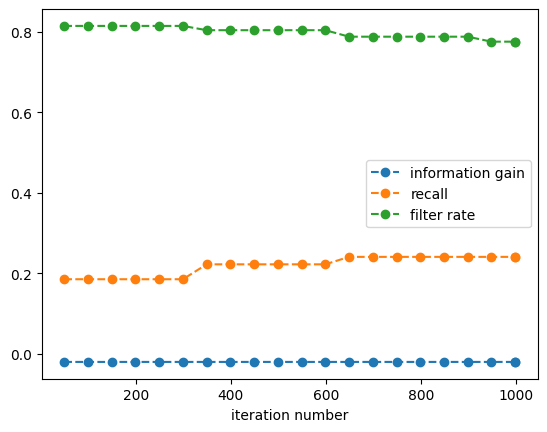

In [154]:
plot_results(results)

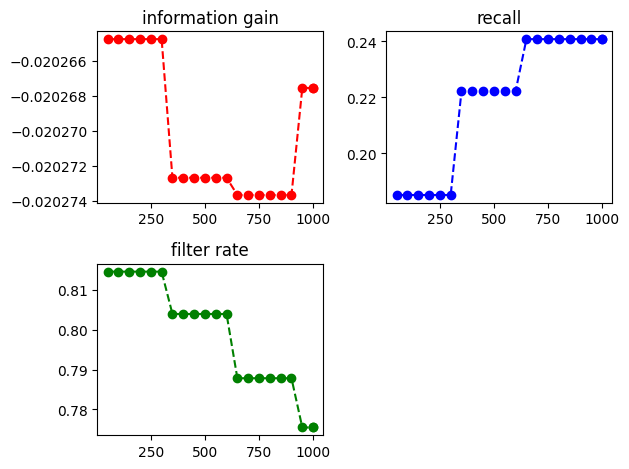

In [155]:
plot_seperator(results)

#### step_size= 0.01

In [156]:
if __name__ == '__main__':
    np.random.seed(1111)
    x1 = intialPoint('Credit_Amt', new_train_set)
    y1 = intialPoint('number_of_Credit', new_train_set)
    step_size = 0.01
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithUpDownPenaltyRecall(point, x_name, y_name, upperbound, new_train_set)

initial  point x1:1377799.0, y1:20.0
recall:-0.18518518518518517, sigmoid:0.4685600536992198
gradIG:
[[ 1.26090175e-12]
 [-8.00902673e-06]]
gradRecall:
[[0.        ]
 [0.00462963]]
gradPenaltyDown:
[[7.25795272e-07]
 [5.00000000e-02]]
gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-8.30670555e-12]
 [ 2.66025370e-05]]
n=1, new x1:1377799.0, new y1: 20.00000026602537,
information gain: -0.02026582950449117, recall:0.18518518518518517, filter rate:0.8240007723498745
********************************
new_gradIG:
[[-5.31300013e-11]
 [-7.74154925e-06]]
new_gradRecall:
[[0.        ]
 [0.00462963]]
new_gradPenaltyDown:
[[7.25795272e-07]
 [4.99999993e-02]]
new_gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
new_Hessian matrix:
[[1.00000000e+00 5.37076386e-06]
 [5.37076386e-06 3.12691071e-02]]
recall:0.18518518518518517, sigmoid:0.8488905593620004
update_direction:
[[1.34569239e-10]
 [5.65812208e-07]]
n=2, new x1:1377799.0, new y1: 2

In [157]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,1377799.0,5.984149,1377799.0,6.018711,-0.020267,0.500000,0.483491
996,997.0,1377799.0,6.018711,1377799.0,6.053274,-0.020267,0.500000,0.483491
997,998.0,1377799.0,6.053274,1377799.0,6.018538,-0.020267,0.500000,0.483491
998,999.0,1377799.0,6.018538,1377799.0,5.984149,-0.020265,0.574074,0.417310
999,1000.0,1377799.0,5.984149,1377799.0,6.018711,-0.020267,0.500000,0.483491


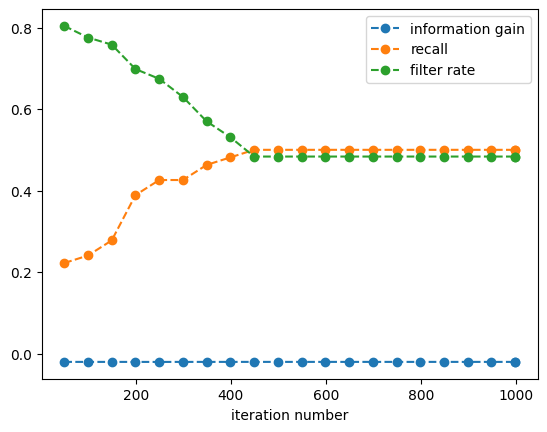

In [158]:
plot_results(results)

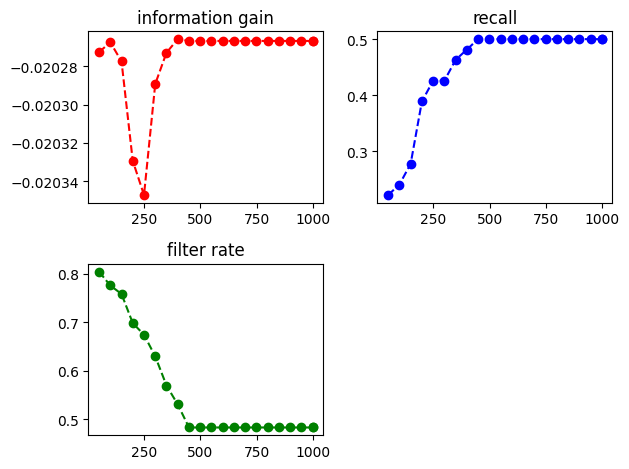

In [159]:
plot_seperator(results)

#### step_size = 0.1

In [161]:
if __name__ == '__main__':
    np.random.seed(1111)
    x1 = intialPoint('Credit_Amt', new_train_set)
    y1 = intialPoint('number_of_Credit', new_train_set)
    step_size = 0.1
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithUpDownPenaltyRecall(point, x_name, y_name, upperbound, new_train_set)

initial  point x1:1377799.0, y1:20.0
recall:-0.18518518518518517, sigmoid:0.4685600536992198
gradIG:
[[ 1.26090175e-12]
 [-8.00902673e-06]]
gradRecall:
[[0.        ]
 [0.00462963]]
gradPenaltyDown:
[[7.25795272e-07]
 [5.00000000e-02]]
gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-8.30670555e-12]
 [ 2.66025370e-05]]
n=1, new x1:1377799.0, new y1: 20.0000026602537,
information gain: -0.02026582950449117, recall:0.18518518518518517, filter rate:0.8240007723498745
********************************
new_gradIG:
[[-5.31300013e-11]
 [-7.74155388e-06]]
new_gradRecall:
[[0.        ]
 [0.00462963]]
new_gradPenaltyDown:
[[7.25795272e-07]
 [4.99999933e-02]]
new_gradPenaltyUp:
[[4.57944632e-08]
 [1.20192308e-03]]
new_Hessian matrix:
[[1.00000000e+00 5.37077093e-06]
 [5.37077093e-06 3.12691482e-01]]
recall:0.18518518518518517, sigmoid:0.8488905593620004
update_direction:
[[1.34569427e-10]
 [5.65813301e-06]]
n=2, new x1:1377799.0, new y1: 20

In [162]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,1377799.0,106.237278,1377799.0,105.147469,-0.020311,0.0,0.987884
996,997.0,1377799.0,105.147469,1377799.0,104.156556,-0.020311,0.0,0.987787
997,998.0,1377799.0,104.156556,1377799.0,105.198963,-0.020311,0.0,0.987884
998,999.0,1377799.0,105.198963,1377799.0,106.237278,-0.020311,0.0,0.987884
999,1000.0,1377799.0,106.237278,1377799.0,105.147469,-0.020311,0.0,0.987884


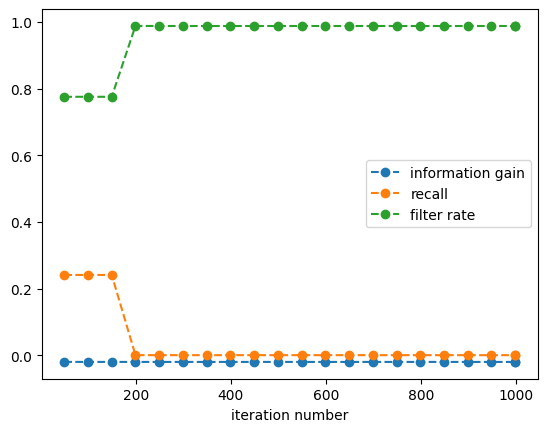

In [163]:
plot_results(results)

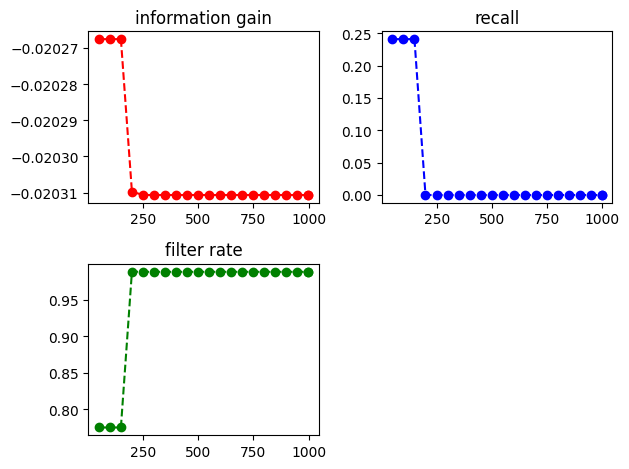

In [164]:
plot_seperator(results)

### GridSearch

In [ ]:
eta_credit_amt = [10, 100, 1000, 10000, 100000]
eta_number_of_credit = [0.01, 0.1, 1, 10]
results = list()
for learning_rate_credit_amt in eta_credit_amt:
    for learning_rate_number_of_credit in eta_number_of_credit:
        tmp_result = pd.DataFrame()
        step_size = np.array([[learning_rate_credit_amt], [learning_rate_number_of_credit]])
        np.random.seed(1111)
        x1 = intialPoint('Credit_Amt', new_train_set)
        y1 = intialPoint('number_of_Credit', new_train_set)
        print(f'initial  point x1:{point[0,0]}, y1:{point[1,0]}')
        print(f'eta_credit_amt:{learning_rate_credit_amt}, eta_number_of_credit: {learning_rate_number_of_credit}')
        tmp_result = BFGSWithUpDownPenaltyRecallUnitVector(point, x_name, y_name, upperbound, train_set)

# information gain find initial point for newton method

In [11]:
credit_amt_median = SplitMedian(train_set, 'Credit_Amt')
number_of_credit_median = SplitMedian(train_set, 'number_of_Credit')

len of median: 17787
len of median: 218


In [12]:
credit_amt_median = np.percentile(credit_amt_median, np.linspace(10, 100, 10))
number_of_credit_median = np.percentile(number_of_credit_median, np.linspace(10, 100, 10))
print(credit_amt_median, '\n', number_of_credit_median)

[  562523.3   990990.8  1106412.1  1236799.5  1396903.   1600802.5
  1999435.   2459497.5  3365424.1 23202000. ] 
 [ 22.2  43.9  65.6  87.3 111.  136.7 189.6 282.1 325.2 847.5]


In [21]:
def Search2Rule(xRange, yRange, x, y, defaultX, defaultY, SAR, Non_SAR, train_set, LOGIC, SAR_type):
    numberOfSAR = [[0] * SLICE for i in range(SLICE)] # SAR個數
    recallRate = [[0] * SLICE for i in range(SLICE)]
    filterRate = [[0] * SLICE for i in range(SLICE)]
    harmonicRecallFilter = [[0] * SLICE for i in range(SLICE)]
    information_gain = [[0] * SLICE for i in range(SLICE)]
    total_cnt = train_set.shape[0]
    father_entropy = Entropy(train_set, 'TO_SAR')
    
#     results = pd.DataFrame(columns = [x, y, 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
#                                   'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
    
    for i in range(len(xRange)):
        for j in range(len(yRange)):
            thre1 = xRange[i]
            thre2 = yRange[j]
            if thre1 < defaultX or thre2 < defaultY:
                continue
            idx1 = set(train_set[train_set[x] >= thre1].index)
            idx2 = set(train_set[train_set[y] >= thre2].index)
        
            idx = list(idx1 & idx2) # 閥值x>= "且" 閥值y>=
            new_SAM_1 = train_set.iloc[idx]
            new_SAM_0 = train_set.drop(index= new_SAM_1.index)
        
            if len(set(new_SAM_0.index) & set(new_SAM_1.index)) != 0:
                raise ValueError('new SAM 0 and new SAM 1 overlapped!')
            
            if len(new_SAM_0) == 0 or len(new_SAM_1) == 0:
                continue
        
            TP = new_SAM_1[new_SAM_1[SAR_type] != 0].shape[0]
            TN = new_SAM_0[new_SAM_0[SAR_type] == 0].shape[0]
            FP = new_SAM_1[new_SAM_1[SAR_type] == 0].shape[0]
            FN = new_SAM_0[new_SAM_0[SAR_type] != 0].shape[0]
        
            numberOfSAR[i][j] = TP
            recallRate[i][j] = TP / (TP + FN)
            filterRate[i][j] = (TN + FN) / (TP + FP + TN + FN)
            harmonicRecallFilter[i][j] = ((1 + beta * beta) * recallRate[i][j] * filterRate[i][j]) \
                        / (recallRate[i][j] + beta * beta * filterRate[i][j])
            #print(f'new_SAM_0: {len(new_SAM_0)}, new_SAM_1: {len(new_SAM_1)}, val1: {thre1}, val2: {thre2}')
            condition_entropy_0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total_cnt)
            condition_entropy_1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total_cnt)
            information_gain[i][j] = father_entropy - (condition_entropy_0 + condition_entropy_1)
            
            
#             results = results.append({x:thre1, y: thre2, 'information gain': information_gain[i][j], 'SAR':SAR.shape[0], \
#                             'Non SAR':Non_SAR.shape[0],\
#                             'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
#                             'newSAM=0_SAR=0(TN)':TN, 'recall': recallRate[i][j],\
#                             'filter rate':filterRate[i][j]}, ignore_index = True)
               
    if LOGIC == 'AND':
        mat = recallRate
        #mat = information_gain
    elif LOGIC == 'OR':
        mat = harmonicRecallFilter
        #mat = information_gain
        
    max_pos = []
    maxVal = np.amax(mat)
    countMax = 0
    countZero = 0
    
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j] == maxVal:
                countMax += 1
            if mat[i][j] == 0:
                countZero += 1
    print('max val: ', maxVal, 'number of max val: ', countMax)
    for i in range(min(max(RANK, countMax), 100 - countZero)):
        idx = np.array(mat).argmax()
        max_pos.append(idx)
        print('{}th, information gain: {}, recall: {}, val1: {}, val2: {}'.format(idx \
                , information_gain[int(idx / SLICE)][idx % SLICE], recallRate[int(idx / SLICE)][idx % SLICE] \
                , xRange[int(idx / SLICE)], yRange[int(idx % SLICE)]))
        mat[int(idx / SLICE)][idx % SLICE] = -1
    
    print('*' * 32)
    candidate_rule = []
    for i in range(min(RANK, 100 - countZero)):
        idx = max_pos[-(i + 1)]
        val_IG = information_gain[int(idx / SLICE)][idx % SLICE]
        val_recall = recallRate[int(idx / SLICE)][idx % SLICE]
        val1 = xRange[int(idx / SLICE)]
        val2 = yRange[idx % SLICE]
        candidate_rule.append([val_IG, val_recall, val1, val2])
    
    return candidate_rule

In [22]:
# Hyper parameter settings
RANK = 10
SLICE = 10
beta = 2 # give recall weight=2

In [23]:
default_credit_amt = 0
default_number_of_credit = 0
LOGIC = 'AND'
SAR_type= 'TO_SAR'
candidate_rule1 = Search2Rule(credit_amt_median, number_of_credit_median, 'Credit_Amt' \
                             , 'number_of_Credit', default_credit_amt, default_number_of_credit \
                             , SAR, Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.052434456928838954 number of max val:  3
0th, information gain: 9.060926979891776e-05, recall: 0.052434456928838954, val1: 562523.3, val2: 22.200000000000003
10th, information gain: 7.523403772261017e-05, recall: 0.052434456928838954, val1: 990990.8, val2: 22.200000000000003
20th, information gain: 4.3827517341325783e-05, recall: 0.052434456928838954, val1: 1106412.1, val2: 22.200000000000003
30th, information gain: 4.992432042238287e-05, recall: 0.04119850187265917, val1: 1236799.5, val2: 22.200000000000003
40th, information gain: 3.259703496029387e-05, recall: 0.03745318352059925, val1: 1396903.0, val2: 22.200000000000003
50th, information gain: 1.935493109743447e-05, recall: 0.0299625468164794, val1: 1600802.5, val2: 22.200000000000003
60th, information gain: 1.9285234815258345e-05, recall: 0.02247191011235955, val1: 1999435.0, val2: 22.200000000000003
70th, information gain: 2.9679302226824633e-05, recall: 0.011235955056179775, val1: 2459497.5000000005, val2: 22.2000000

In [24]:
candidate_rule1

[[2.285528479119281e-06, -1, 562523.3, 65.6],
 [6.677541294759781e-05, -1, 562523.3, 43.900000000000006],
 [2.9679302226824633e-05, -1, 2459497.5000000005, 22.200000000000003],
 [1.9285234815258345e-05, -1, 1999435.0, 22.200000000000003],
 [1.935493109743447e-05, -1, 1600802.5, 22.200000000000003],
 [3.259703496029387e-05, -1, 1396903.0, 22.200000000000003],
 [4.992432042238287e-05, -1, 1236799.5, 22.200000000000003],
 [4.3827517341325783e-05, -1, 1106412.1, 22.200000000000003],
 [7.523403772261017e-05, -1, 990990.8, 22.200000000000003],
 [9.060926979891776e-05, -1, 562523.3, 22.200000000000003]]